# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Authors:** Claire Meyer, Nicolas Furrer, Philipp Schuler  
**Due date:** 08.05.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

# End of cell
print("Done")

Done


## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [ ]:
# Import
import scipy.io

# Data loading
data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

# Size of data
print(f"Class A : {a.shape} \nClass B : {b.shape} \nClass c : {c.shape}")

# End of cell
print("Done")

### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

To implement the Bayers method in a 2D case, we use the discriminant function :

$g_i(x) = - \dfrac{1}{2}(x-\mu_i)\Sigma^{-1}_i(x-\mu_i)^T+\textrm{ln}P(w_i)+c_i$

Where :
- $x$ is the point to be classified
- $\mu_i$ is the mean of the $i$-th distribution
- $\Sigma_i$ is the covariance matrix of the $i$-th distribution
- $P(w_i)$ is the propability of a point to by in class i (In our case this probability is equal to 1/3)
- $c_i$ is a parameter who is equal to $\textrm{ln}\dfrac{1}{2\pi|\Sigma_i|^{1/2}}$

Then to find the decision curve between to class we solve this equation :

$g_i(x)-g_j(x) = 0$

Where : 
- $g_i$is the discriminant function for the class i
- $g_j$is the discriminant function for the class j

This gives us the hyperplan equation that divides classes i and j. We can plot those hyperplans as decision curves. They represent decision curves for the complete Bayesian classification.

From the complete Bayesian decision curves, we can compute the simplified decisions curves, for the simplified Bayesian classification. The process is explained later.


When looking at the data of classes A, B and C, we can see that a diagonal covariance matrix is probably enough to model the data, but we decided to use a full covariance matrix for more precision, and because it has no drawback in our case (we have no computational limitations). 

In [ ]:
# Imports
import numpy as np
from sympy.solvers import solve
from sympy import symbols
import matplotlib.pyplot as plt
%matplotlib inline
import random as rd

# Computes the covariance matrix sigma.
# Parameters : Data (200x2)(number mesure x dimension), mean of the data (1x2)(1 x dimension)
# Return value : Covariance matrix sigma (2x2)(dimension x dimension)
def covariance(data, data_mu):
    X = data-data_mu
    M = data.shape[0]
    data_sigma = 1/M*(X.T @ X)
    return data_sigma

# Computes the value of the discriminant funtion for a data point.
# Parameters : Point to evalute (1x2), Data (200x2)(number mesure x dimension), Propability to be in a class
# Return value : Value of the discriminant function a the data_point
def discriminantFonction(data_point, data, Pw):
    data_mu = np.mean(data, axis = 0)
    data_sigma = covariance(data, data_mu)
    c = np.log(2*np.pi*np.sqrt(np.linalg.det(data_sigma)))
    g =  -1/2*((data_point-data_mu)@np.linalg.inv(data_sigma)@(data_point-data_mu).T)+np.log(Pw)-c
    return g

# Compute the class of a data_point in function of 3 class of point .
# Parameters : Point to evalute (1x2), 3 class data  (200x2)(number mesure x dimension), Propability to be in a class
# Return value : the Class where the point is, A,B or C
def completeBayesClassification(data_point, class_a, class_b, class_c, Pw):
    dist = np.zeros(3)
    dist[0] = discriminantFonction(data_point, class_a, Pw)
    dist[1] = discriminantFonction(data_point, class_b, Pw)
    dist[2] = discriminantFonction(data_point, class_c, Pw)
    
    return chr(np.argmax(dist)+65) # to get a, b or c class

# Compute the class of a data_point in function of 3 class of point with the simplified decision curve.
# Parameters : Point to evalute (1x2), 3 equation value for each class
# Return value : the Class where the point is, A,B or C
def simplifiedBayesClassification(data_point, equ1, equ2, equ3):
    if data_point[1] > equ1:
        if data_point[0] > equ2:
            return 'B'
        else:
            return 'C'
    else:
        if data_point[0] > equ3:
            return 'A'
        else:
            return 'C'

# Computes different parameter : mean, sigma inverse and parameter c for equation page 12 Cours 5.
# Parameter : Data (200x2)(number mesure x dimension)
# Return value : mean (1x2)(1 x dimension, inverse matrix sigma (2x2)(dimension x dimension), parameter c (1x1)
def computation(data):
    mean = np.mean(data, axis = 0)
    sigma = covariance(data, mean)
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    c = np.log(2*np.pi*np.sqrt(sigma_det))
    return mean, sigma_inv, c

# Finds the decision curves between two data set.
# Parameters : 2 Data (200x2)(number mesure x dimension), choice_variable 0 : x =, 1 : y =
# Return value : equation of decision curves (2 equation)
def decisionCurve(data_i, data_j, choice_variable):
    
    mean_i, sigma_i_inv, c_i = computation(data_i) 
    mean_j, sigma_j_inv, c_j = computation(data_j) 
    
    x, y = symbols('x, y', integer=True)
    X = np.array([[x,y]])
    
    g_i = -1/2*((X-mean_i)@sigma_i_inv@(X-mean_i).T)+np.log(1/3)-c_i
    g_j = -1/2*((X-mean_j)@sigma_j_inv@(X-mean_j).T)+np.log(1/3)-c_j
    g = g_i-g_j
    
    if choice_variable:
        equ = solve(g[0][0],x)
    else:
        equ = solve(g[0][0],y)
    return equ

# Evaluates a equation with the a vector of value x0.
# Parameters : 1 equation with x as a parameter, vector of value to evaluate the equation
# Return value : vector of value of y
def evaluateXY(equation, input_value):
    y = symbols('y', integer=True)
    output_value = np.empty(input_value.shape[0])
    for i in range(input_value.shape[0]):
        output_value[i] = equation.subs(y, input_value[i])
    
    return output_value

In [ ]:
# Decision curves equations
eq_comp_1 = decisionCurve(a,b,1)
eq_comp_2 = decisionCurve(b,c,1)
eq_comp_3 = decisionCurve(c,a,1)

# Simplified decision_curve
x, y = symbols('x, y', integer=True)
eq_simp_1_x = round(decisionCurve(a,b,0)[1].subs(x,0))
eq_simp_2_y = round(eq_comp_2[1].subs(y,0))
eq_simp_3_y = round(eq_comp_3[1].subs(y,0))

# Computation of XY for graph
step_value = 0.1

# Full hyperplans
y_full_1 = np.arange(start=-25, stop=5,step=step_value)
y_full_2 = np.arange(start=-40, stop=25,step=step_value)
y_full_3 = np.arange(start=-40, stop=25,step=step_value)

x_full_1_1 = evaluateXY(eq_comp_1[0],y_full_1)
x_full_1_2 = evaluateXY(eq_comp_1[1],y_full_1)

x_full_2_1 = evaluateXY(eq_comp_2[0],y_full_2)
x_full_2_2 = evaluateXY(eq_comp_2[1],y_full_2)

x_full_3_1 = evaluateXY(eq_comp_3[0],y_full_3)
x_full_3_2 = evaluateXY(eq_comp_3[1],y_full_3)

# Intersected hyperplans
y_inter_1_1 = np.concatenate(([2.71],np.arange(start=2.8,stop=5,step=step_value)))
y_inter_1_2 = np.concatenate(([-21.217],np.arange(start=-21.1,stop=2.1,step=step_value),[2.109]))

y_inter_2_1 = np.arange(start=2.8,stop=25,step=step_value)
y_inter_2_2 = np.arange(start=2.1,stop=25,step=step_value)

y_inter_3_1 = np.arange(start=-40,stop=2.8,step=step_value)
y_inter_3_2 = np.arange(start=-40,stop=2.15,step=step_value)

x_inter_1_1 = evaluateXY(eq_comp_1[1],y_inter_1_1)
x_inter_1_2 = evaluateXY(eq_comp_1[1],y_inter_1_2)

x_inter_2_1 = evaluateXY(eq_comp_2[0],y_inter_2_1)
x_inter_2_2 = evaluateXY(eq_comp_2[1],y_inter_2_2)

x_inter_3_1 = evaluateXY(eq_comp_3[0],y_inter_3_1)
x_inter_3_2 = evaluateXY(eq_comp_3[1],y_inter_3_2)
 
# End of cell
print("Done")

In [ ]:
# Equation of decision_curve
print(f"Round equation between class A and B :")
print(f"\ty = {eq_simp_1_x}")
print(f"Round equation between class B and C :")
print(f"\tx = {eq_simp_2_y}")
print(f"Round equation between class C and A :")
print(f"\tx = {eq_simp_3_y}")

# Plot images
n_lin = 3
n_col = 1
size = 15
alpha_val = 0.2
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size/2))

ax[0].plot(a[:,0],a[:,1],".",color="#0072BD")
ax[0].plot(b[:,0],b[:,1],".",color="#A2142F")
ax[0].plot(c[:,0],c[:,1],".",color="#EDB120")

ax[0].plot(x_full_1_1,y_full_1,color="#7E2F8E")
ax[0].plot(x_full_2_1,y_full_2,color="#D95319")
ax[0].plot(x_full_3_1,y_full_3,color="#77AC30")

ax[0].plot(x_full_1_2,y_full_1,color="#7E2F8E")
ax[0].plot(x_full_2_2,y_full_2,color="#D95319")
ax[0].plot(x_full_3_2,y_full_3,color="#77AC30")

ax[0].set_title("Classes A, B and C 2D representation with complete Bayesian hyperplans")
ax[0].legend(("Class A","Class B","Class C","AB decision curves","BC decision curves","AC decision curves"))



ax[1].plot(a[:,0],a[:,1],".",color="#0072BD")
ax[1].plot(b[:,0],b[:,1],".",color="#A2142F")
ax[1].plot(c[:,0],c[:,1],".",color="#EDB120")

ax[1].plot(x_inter_1_1,y_inter_1_1,color="#7E2F8E")
ax[1].plot(x_inter_2_1,y_inter_2_1,color="#D95319")
ax[1].plot(x_inter_3_1,y_inter_3_1,color="#77AC30")

ax[1].plot(x_inter_1_2,y_inter_1_2,color="#7E2F8E")
ax[1].plot(x_inter_2_2,y_inter_2_2,color="#D95319")
ax[1].plot(x_inter_3_2,y_inter_3_2,color="#77AC30")

ax[1].set_xlim([-20,20])
ax[1].set_ylim([-10,10])

ax[1].set_title("Classes A, B and C 2D representation with complete Bayesian decision curves")
ax[1].legend(("Class A","Class B","Class C","AB decision curves","BC decision curves","AC decision curves"))



ax[2].plot(a[:,0],a[:,1],".",color="#0072BD")
ax[2].plot(b[:,0],b[:,1],".",color="#A2142F")
ax[2].plot(c[:,0],c[:,1],".",color="#EDB120")

ax[2].plot([eq_simp_3_y,20],[eq_simp_1_x,eq_simp_1_x],color="#7E2F8E")
ax[2].plot([eq_simp_2_y,eq_simp_2_y],[eq_simp_1_x,30],color="#D95319")
ax[2].plot([eq_simp_3_y,eq_simp_3_y],[-25,eq_simp_1_x],color="#77AC30")

ax[2].set_xlim([-20,20])
ax[2].set_ylim([-10,10])

ax[2].set_title("Classes A, B and C 2D representation with simplified Bayesian decision curves")
ax[1].legend(("Class A","Class B","Class C","AB decision curves","BC decision curves","AC decision curves"))

# End of cell
print("Done")

On the above Figure are plotted the decisions hyperplans : 
- On the first, we have the hyperplans corresponding to the complete Bayesian classification. They are quadratic, so there are two curves for each hyperplan (for a total of 2x3=6 curves). 
- On the second, we have the boundaries between the three classes, defined by the complete Bayesian hyperplan. They are intersecting as illustrated because the discrimination criteria is based on the maximum value that the disciminant function takes for the three classes at the considered point.
- On the third, we have the simplified curves. They are obtained by taking the equations (for example equation between classes A and B) :

$y=-0.00270195666350582\cdot x \pm 11.786193018351\cdot \sqrt{-3.51523290159705e-5\cdot x^2 - 0.0128778860105878 \cdot x + 1}- 10.1975370992027$

We round each parameter to its closest integer :

$y=-0\cdot x \pm 12\cdot \sqrt{-0\cdot x^2 - 0 \cdot x + 1}- 10$

$y=\pm 12 - 10$

Then, we keep the most "logical" one (by looking a the complete Bayesian decision curves and the data), which give us three equations :
- Between A and B : $y=+2$
- Between B and C : $x=-6$
- Between C and A : $x=-8$

The first two plots of the above Figure, we can see how the hyperplans separate the data, and the consequences of them being quadratic. Let's take the AB decision curves (and **ignore the class C and its own boudaries**). The curves we are looking at are the two violet hyperbole looking ones. Inside the hyperbole is the class A, and outside is the class B. That means that as long as we stay close to the original datasets, the classification is fairly accurate and similar as the one a human would give. But if we get far away from the original dataset, the results start to differ to the ones a human would give, because we don't "draw" the other part of the quadratic solution "in our heads". It doesn't mean that the classified solution are wrong (or right), though, just that trying to classify points that are so remote from the original dataset would be inadequate. That's because if testing points were to be generated the same way training points had been generated, they wouldn't be so far away from the original dataset.

On the last plot of the above Figure, that behavior is not present, because we only kept the "logical" part. Again, "logical" is used loosely here, because it's only logical to us humans since we extrapolate the data a certain way, but points far removed from the original data set do not have a right or wrong label, they are just inadequate for the classification based on training with the given dataset.

More quantified comparisons as well as analysis are given later, as to include the Mahalanobis distance classifier as well.

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The Mahalanobis distance is defined by :

$d_m = \left( \left( x-\mu_i \right) \Sigma^{-1}_{i} \left( x-\mu_i \right)^T \right)^{1/2}$

Where :
- $x$ is the point to be classified
- $\mu_i$ is the mean of the $i$-th distribution
- $\Sigma_i$ is the covariance matrix of the $i$-th distribution

The Mahalanobis distance is a measure of the distance between a point P and a distribution D, introduced by P. C. Mahalanobis in 1936. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis. If each of these axes is re-scaled to have unit variance, then the Mahalanobis distance corresponds to standard Euclidean distance in the transformed space. The Mahalanobis distance is thus unitless and scale-invariant, and takes into account the correlations of the data set [[1]][maha].

[maha]: https://en.wikipedia.org/wiki/Mahalanobis_distance

In [ ]:
# Computes the Mahalanobis distance between a data point and a data set. 
# A GMM is used on the data set (mu and sigma) to compute the distance.
# Parameters : point the data point, data, the list of points in the data set
# Return value : the Mahalanobis distance
def mahalanobisDistance(point, data):
    mean_value = np.mean(data, axis = 0)
    sigma_value = covariance(data, mean_value)
    return np.sqrt((point-mean_value)@np.linalg.inv(sigma_value)@(point-mean_value).T)

# Computes to which data set the data point belongs to, using the Mahalanobis distance.
# Parameters : the data point and the three candidate data sets
# Return value : the name of the class the data point belongs to
def mahalanobisClassification(point, class_a, class_b, class_c):
    dist = np.zeros(3)
    dist[0] = mahalanobisDistance(point, class_a)
    dist[1] = mahalanobisDistance(point, class_b)
    dist[2] = mahalanobisDistance(point, class_c)
    
    return chr(np.argmin(dist)+65) # to get a, b or c class

In [ ]:
# Plot images
n_lin = 2
n_col = 2
size = 10
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
for i in range(n_lin):
    for j in range(n_col):
        ax[i][j].plot(a[:,0],a[:,1],".",color="#0072BD")
        ax[i][j].plot(b[:,0],b[:,1],".",color="#A2142F")
        ax[i][j].plot(c[:,0],c[:,1],".",color="#EDB120")
        ax[i][j].plot(x_inter_1_1,y_inter_1_1,color="#7E2F8E")
        ax[i][j].plot(x_inter_2_1,y_inter_2_1,color="#D95319")
        ax[i][j].plot(x_inter_3_1,y_inter_3_1,color="#77AC30")

# Test points
Pw = 1/3
range_num = 20

print(f"Point testing results :")
print(f"\tfor points in 'reasonable positions' around class A:")
print(f"\t\tPoint\t\t\tComplete Bayesian classification\tSimplified Bayesian classification\tMahalanobis distance classification")
for i in range(range_num):
    x = rd.uniform(-5,15)
    y = rd.uniform(-6,1)
    point = np.array([[x,y]])
    ax[0][0].plot(x,y,".",color="k",markersize=10)
    print(f"\t\t[{point[[0][0]][0]:6.2f},{point[[0][0]][1]:6.2f}]\t\tclass {completeBayesClassification(point,a,b,c,Pw)}\t\t\t\t\tclass {simplifiedBayesClassification([x,y],eq_simp_1_x,eq_simp_2_y,eq_simp_3_y)}\t\t\t\t\tclass {mahalanobisClassification(point,a,b,c)}")
    

print(f"\n\tfor points in 'reasonable positions' around class B:")
print(f"\t\tPoint\t\t\tComplete Bayesian classification\tSimplified Bayesian classification\tMahalanobis distance classification")
for i in range(range_num):
    x = rd.uniform(-5,15)
    y = rd.uniform(1,10)
    point = np.array([[x,y]])
    ax[0][1].plot(x,y,".",color="k",markersize=10)
    print(f"\t\t[{point[[0][0]][0]:6.2f},{point[[0][0]][1]:6.2f}]\t\tclass {completeBayesClassification(point,a,b,c,Pw)}\t\t\t\t\tclass {simplifiedBayesClassification([x,y],eq_simp_1_x,eq_simp_2_y,eq_simp_3_y)}\t\t\t\t\tclass {mahalanobisClassification(point,a,b,c)}")

print(f"\n\tfor points in 'reasonable positions' around class C:")
print(f"\t\tPoint\t\t\tComplete Bayesian classification\tSimplified Bayesian classification\tMahalanobis distance classification")
for i in range(range_num):
    x = rd.uniform(-15,-5)
    y = rd.uniform(-15,15)
    point = np.array([[x,y]])
    ax[1][0].plot(x,y,".",color="k",markersize=10)
    print(f"\t\t[{point[[0][0]][0]:6.2f},{point[[0][0]][1]:6.2f}]\t\tclass {completeBayesClassification(point,a,b,c,Pw)}\t\t\t\t\tclass {simplifiedBayesClassification([x,y],eq_simp_1_x,eq_simp_2_y,eq_simp_3_y)}\t\t\t\t\tclass {mahalanobisClassification(point,a,b,c)}")

print(f"\n\tfor points in 'unreasonable positions' below classes A and C:")
print(f"\t\tPoint\t\t\tComplete Bayesian classification\tSimplified Bayesian classification\tMahalanobis distance classification")
for i in range(range_num):
    x = rd.uniform(-15,15)
    y = rd.uniform(-10,-40)
    point = np.array([[x,y]])
    ax[1][1].plot(x,y,".",color="k",markersize=10)
    print(f"\t\t[{point[[0][0]][0]:6.2f},{point[[0][0]][1]:6.2f}]\t\tclass {completeBayesClassification(point,a,b,c,Pw)}\t\t\t\t\tclass {simplifiedBayesClassification([x,y],eq_simp_1_x,eq_simp_2_y,eq_simp_3_y)}\t\t\t\t\tclass {mahalanobisClassification(point,a,b,c)}")

# Plots legends and title
for i in range(n_lin):
    for j in range(n_col):
        ax[i][j].plot(x_inter_1_2,y_inter_1_2,color="#7E2F8E")
        ax[i][j].plot(x_inter_2_2,y_inter_2_2,color="#D95319")
        ax[i][j].plot(x_inter_3_2,y_inter_3_2,color="#77AC30")
        ax[i][j].legend(("Class A","Class B","Class C","AB decision curves","BC decision curves","AC decision curves","Tested points"))

ax[0][0].set_xlim([-20,20])
ax[0][0].set_ylim([-15,15])
ax[0][1].set_xlim([-20,20])
ax[0][1].set_ylim([-15,15])
ax[1][0].set_xlim([-20,20])
ax[1][0].set_ylim([-15,15])
ax[1][1].set_xlim([-20,20])
ax[1][1].set_ylim([-40,10])

ax[0][0].set_title("Classes A, B and C 2D representation with class A tested points")
ax[0][1].set_title("Classes A, B and C 2D representation with class B tested points")
ax[1][0].set_title("Classes A, B and C 2D representation with class C tested points")
ax[1][1].set_title("Classes A, B and C 2D representation with tested points below classes A and C")

# End of cell
print("Done")

With the above results, we observe that :
- For points that are relevant to the initial data sets, the classification is mostly correct (see quantification below), for all three methods (complete Bayesian classification, simplified Bayesian classification, and Mahalanobis distance classification). That shows that the models chosen to modelize the data are relevant models.
- For points far removed from the original data sets, the classification is :
    - the same between complete Bayesian and Mahalanobis distance classification methods; 
    - but is different for the simplified Bayesian classification. 
- That's because if we neglect the constants, the complete Bayesian discrimant can be simplified as the Mahalanobis distance; and here, the constants are negligeable; so both yields the same results. But the simplified Bayesian classification has drastically different decision curves far removed from the original datasets, so the results are different.
- For points far removed from the original data sets, it makes little sense to try and classify them, but again :
    - complete Bayesian and Mahalanobis distance classification methods yields the same results;
    - simplified Bayesian classification produces different results because of different decision curve.
- It makes little sense, because those points do not belong to any of the classes; if the testing points were generated the same way as the training points, they would not be so far removed from the original, training data sets. So the classification produced is neither right nor wrong; it's just inadequate.

\
\
To assess the validity of those results, let's put aside that the entirety of the datasets were used for training, and use them for testing, and compute the error that we yield this way :

In [ ]:
# Computes error between data set and label.
# Parameters : data sets (200x2), label ('A', 'B' or 'C')
# Return value : error value for bayes_complet, mahalaobis and bayes_simplified
def errorComputation(data, class_char):
    error_bayes_complete = 0
    error_mahalanobis = 0
    error_bayes_simplified = 0
    for i in range(data.shape[0]):
        if completeBayesClassification(data[i,:],a,b,c,Pw) != class_char:
            error_bayes_complete = error_bayes_complete + 1
        if simplifiedBayesClassification(data[i,:], eq_simp_1_x, eq_simp_2_y, eq_simp_3_y) != class_char:
            error_bayes_simplified = error_bayes_simplified + 1
        if mahalanobisClassification(data[i,:],a,b,c) != class_char:
            error_mahalanobis = error_mahalanobis + 1
    return [error_bayes_complete/data.shape[0], error_bayes_simplified/data.shape[0], error_mahalanobis/data.shape[0]]

# Error print
error = np.zeros((4,3))
error[0,:] = errorComputation(a, 'A')
error[1,:] = errorComputation(b, 'B')
error[2,:] = errorComputation(c, 'C')
error[3,:] = error.sum(0)/3

print(f"Classification error")
print(f"\t\t\t|Complete Bayes classification\t|Simplified Bayes classification\t|Mahalanobis distance classification")
print("\t________________|_______________________________|_______________________________________|___________________________________")
print(f"\tClass A\t\t|{error[0][0]:5.3f}\t\t\t\t|{error[0][1]:5.3f}\t\t\t\t\t|{error[0][2]:5.3f}")
print(f"\tClass B\t\t|{error[1][0]:5.3f}\t\t\t\t|{error[1][1]:5.3f}\t\t\t\t\t|{error[1][2]:5.3f}")
print(f"\tClass C\t\t|{error[2][0]:5.3f}\t\t\t\t|{error[2][1]:5.3f}\t\t\t\t\t|{error[2][2]:5.3f}")
print(f"\tAll classes\t|{error[3][0]:5.3f}\t\t\t\t|{error[3][1]:5.3f}\t\t\t\t\t|{error[3][2]:5.3f}")

# End of cell
print("Done")

The classification error on the datasets confirm the previous discussions. The simplified Bayesian classification has an overall higher error rate (6.2% of error rate) than the other two (3.5%). That's because the simplified Bayesian is, well, simplified, and since the training sets (which are also here the testing sets) are overlapping a little, the simplified Bayes classification fares a little less well than the other two. 

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

# End of cell
print("Done")

Done


Done


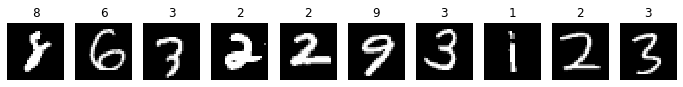

In [4]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)
    
# End of cell
print("Done")

### 2.2 MLP
*Add your implementation and discussion*

#### Model training

SciKit proposes a multi-layer perceptron classifier function 'MLPClassifier'. 
This classifier proposes different optimisers and activation functions. 
We tested all of them to then decide the best classifier for our use case:

 
 | Optimiser | Loss   | Training score | Test score |
 |-----------|-------:|:--------------:|:----------:|
 | Adam      | 0.05   |  0.9899        | 0.962      |
 | SGD       | 0.23   |  0.9246        | 0.917      |
 | L-BFGS    | 120.51 |  0.1169        | 0.108      |
 
[L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) is not optimised for large training sets and this is shown by the tests, as it output random values of loss and score at each iteration. 

[SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) or stochastic gradient descent, is working but takes much more steps to converge than Adam. 

As [Adam](https://www.deeplearning-academy.com/p/ai-wiki-optimization-algorithms) has the best results without optimisation, and SGD seems to not converging very quickly (200 epochs and not converged) we will use Adam for the nexts steps and try to optimise this one

The default parameters are: activation function = "Relu", $\alpha = 10^{-4}$, $\beta_2 = 0.999$ and  $\beta_1 = 0.9$. 

We iterate through each parameter, keeping the best result for the next step.
 
First, we try out different activation functions:


| Activation function | Loss | Training Score | Test Score |
|---------------------|------|----------------|------------|
| Identity            | 0.37 | 0.9155         | 0.906      |
| Logistic            | 0.17 | 0.9522         | 0.947      |
| Tanh                | 0.19 | 0.9469         | 0.942      |
| Relu                | 0.05 | 0.9899         | 0.962      |

With these results we choose to keep the Relu activation function as it shows the best restults out of the box.


Then we test different $\alpha$ values:


| $\alpha$ Values     | Loss | Training Score | Test Score |
|---------------------|------|----------------|------------|
| 0.001               | 0.04 | 0.9927         | 0.967      |
| 0.0001              | 0.05 | 0.9899         | 0.962      |
| 0.00001             | 0.05 | 0.9893         | 0.965      |

As show, the best results are with $\alpha = 0.001$

Keeping the $\alpha$ value, we try different $\beta_2$ values:

| $\beta_2$ Values    | Loss | Training Score | Test Score |
|---------------------|------|----------------|------------|
| 0.99                | 0.03 | 0.9894         | 0.965      |
| 0.999               | 0.04 | 0.9927         | 0.967      |
| 0.9999              | 0.05 | 0.9933         | 0.966      |
| 0.99999             | 0.00 | 0.9961         | 0.963      |
| 0.999999            | 0.01 | 0.9911         | 0.956      |

Now we keep $\beta_2 = 0.99999$

Finally we test different $\beta_1$ values:

| $\beta_1$ Values    | Loss | Training Score | Test Score |
|---------------------|------|----------------|------------|
| 0.1                 | 0.03 | 0.9945         | 0.966      |
| 0.9                 | 0.01 | 0.9961         | 0.963      |
| 0.99                | 0.03 | 0.9825         | 0.948      |
| 0.999               | 0.12 | 0.9603         | 0.949      |

In the end we choose to stay with the Relu activation function, $\alpha = 0.001$, $\beta_1 = 0.9$ and $\beta_2 = 0.99999$, which has 

#### Result output explanation
The result output shows the results for each model (Adam, SGD and L-BFGS) with their respective losses, training score and test score. 

The test score is given by the percentage of characters correctly classified by the neural network.

The graph shows the loss curve of SGD and Adam. This is the loss of each epoch of training.

In [44]:
from sklearn.neural_network import MLPClassifier

def trainClassifiers():
    #definition of the used models
    model_lbfgs = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100), max_iter=200, random_state=1)

    model_adam_1 = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=1e-3, batch_size='auto', 
                    learning_rate='constant', max_iter=200, shuffle=True, random_state=1, 
                    tol=0.0001, verbose=False, warm_start=False, early_stopping=True, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.99999, epsilon=1e-08, n_iter_no_change=10)
    
    model_sgd = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='sgd', alpha=1e-4, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=1, 
                    tol=0.0001, verbose=False, warm_start=False, early_stopping=True, momentum=0.9, nesterovs_momentum=True,
                    validation_fraction=0.1, n_iter_no_change=10)


    model_lbfgs.fit(flattened_training_set, train_labels)
    model_adam_1.fit(flattened_training_set, train_labels)
    model_sgd.fit(flattened_training_set, train_labels)
    
    return model_lbfgs, model_sgd, model_adam_1
    
def computeTestScore(model):
    output = model.predict(flattened_testing_set)
    nb_wrong = 0
    idx_list = []
    for idx, predicted in enumerate(output):
        if predicted != test_labels[idx]:
            nb_wrong = nb_wrong +1 
            idx_list.append(idx)

    return 1-(nb_wrong/test_set_size)

Model results :
	Adam :	loss =   0.03, training score = 0.9945, test score = 0.966
	SGD :	loss =   0.15, training score = 0.9570, test score = 0.941
	LBFGS :	loss = 120.51, training score = 0.1169, test score = 0.108
Done


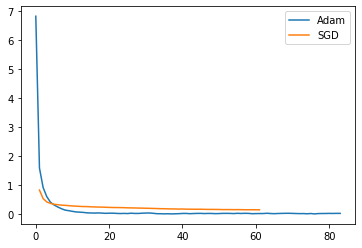

In [45]:
# Flattening training and testing set
flattened_training_set = train_images.reshape(train_set_size, image_shape[0]*image_shape[1])
flattened_testing_set = test_images.reshape(test_set_size,image_shape[0]*image_shape[1])

# Train classifiers
model_lbfgs, model_sgd, model_adam_1 = trainClassifiers()

# Compute test scores
test_score_lbfgs = computeTestScore(model_lbfgs)
test_score_adam_1 = computeTestScore(model_adam_1)
test_score_sgd = computeTestScore(model_sgd)

# Print results
print(f"Model results :")
print(f"\tAdam :\tloss = {model_adam_1.loss_:6.2f}, training score = {model_adam_1.score(flattened_training_set, train_labels):6.4f}, test score = {test_score_adam_1:5.3f}")
print(f"\tSGD :\tloss = {model_sgd.loss_:6.2f}, training score = {model_sgd.score(flattened_training_set, train_labels):6.4f}, test score = {test_score_sgd:5.3f}")
print(f"\tLBFGS :\tloss = {model_lbfgs.loss_:6.2f}, training score = {model_lbfgs.score(flattened_training_set, train_labels):6.4f}, test score = {test_score_lbfgs:5.3f}")

# Plots
plt.plot(model_adam_1.loss_curve_)
plt.plot(model_sgd.loss_curve_)
plt.legend(["Adam", "SGD"])

# End of cell
print("Done")